In [2]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))


In [3]:
# ==========================================
# INTRADAY ELECTRICITY PRICE FORECASTING - EDA
# TARGET: Intraday WAP DK1
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

from helpers.stats import *

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["font.size"] = 10

print("✓ Environment ready")


✓ Environment ready


In [4]:
# ==========================================
# Load processed EnAppSys data
# ==========================================

data_path = Path("data/processed")
df = pd.read_parquet(data_path / "enappsys_features.parquet")

# Ensure CET timezone
if df.index.tz is None:
    df.index = df.index.tz_localize("UTC").tz_convert("CET")

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} → {df.index.max()}")
print(f"Frequency: {pd.infer_freq(df.index)}")

Dataset shape: (35136, 108)
Date range: 2024-01-01 00:00:00+01:00 → 2024-12-31 23:45:00+01:00
Frequency: 15min


In [5]:
# ==========================================
# Define target and feature sets
# ==========================================

TARGET = "price.id.wap.HR WAP DK1"
target = df[TARGET].dropna()

da_price = "price.da.dk1.DA HR Price (EPEX)"
demand = "price.da.dk1.Demand"

gen_features = [c for c in df.columns if c.startswith("gen.")]
id_trade_features = [c for c in df.columns if "price.id.wap" in c and c != TARGET]

print(f"🎯 Target: {TARGET}")
print(f"DA price: {da_price}")
print(f"Demand: {demand}")
print(f"Generation features: {len(gen_features)}")
print(f"Intraday trade features: {len(id_trade_features)}")


🎯 Target: price.id.wap.HR WAP DK1
DA price: price.da.dk1.DA HR Price (EPEX)
Demand: price.da.dk1.Demand
Generation features: 17
Intraday trade features: 35


In [6]:
# ==========================================
# Basic statistics
# ==========================================

print(target.describe())

print("\nNegative prices:", (target < 0).mean())
print("Extreme prices (>100 EUR/MWh):", (target > 100).mean())

norm = test_normality(target)
norm


count    35136.000000
mean        70.575060
std         57.292594
min        -79.080000
25%         39.127500
50%         68.130000
75%         94.242500
max        999.570000
Name: price.id.wap.HR WAP DK1, dtype: float64

Negative prices: 0.042008196721311473
Extreme prices (>100 EUR/MWh): 0.20366575591985428


{'skewness': np.float64(5.349654206672307),
 'kurtosis': np.float64(65.70299749566738),
 'jb_pvalue': np.float64(0.0),
 'interpretation': 'Non-normal'}

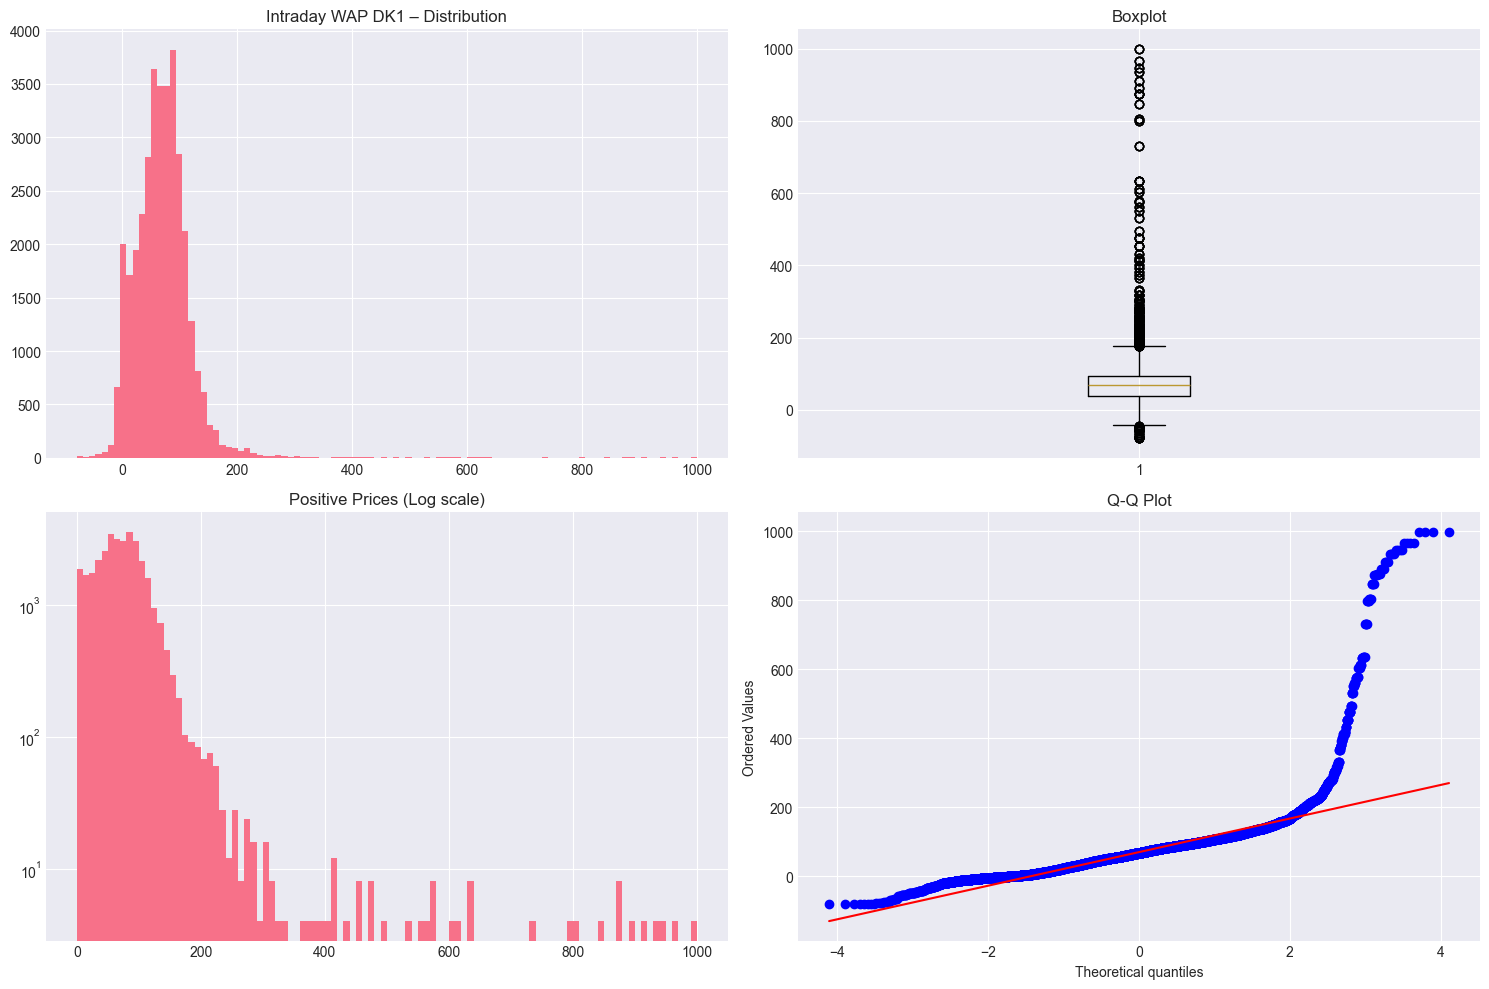

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].hist(target, bins=100)
axes[0,0].set_title("Intraday WAP DK1 – Distribution")

axes[0,1].boxplot(target, vert=True)
axes[0,1].set_title("Boxplot")

axes[1,0].hist(target[target > 0], bins=100)
axes[1,0].set_yscale("log")
axes[1,0].set_title("Positive Prices (Log scale)")

from scipy import stats
stats.probplot(target, dist="norm", plot=axes[1,1])
axes[1,1].set_title("Q-Q Plot")

plt.tight_layout()
plt.show()


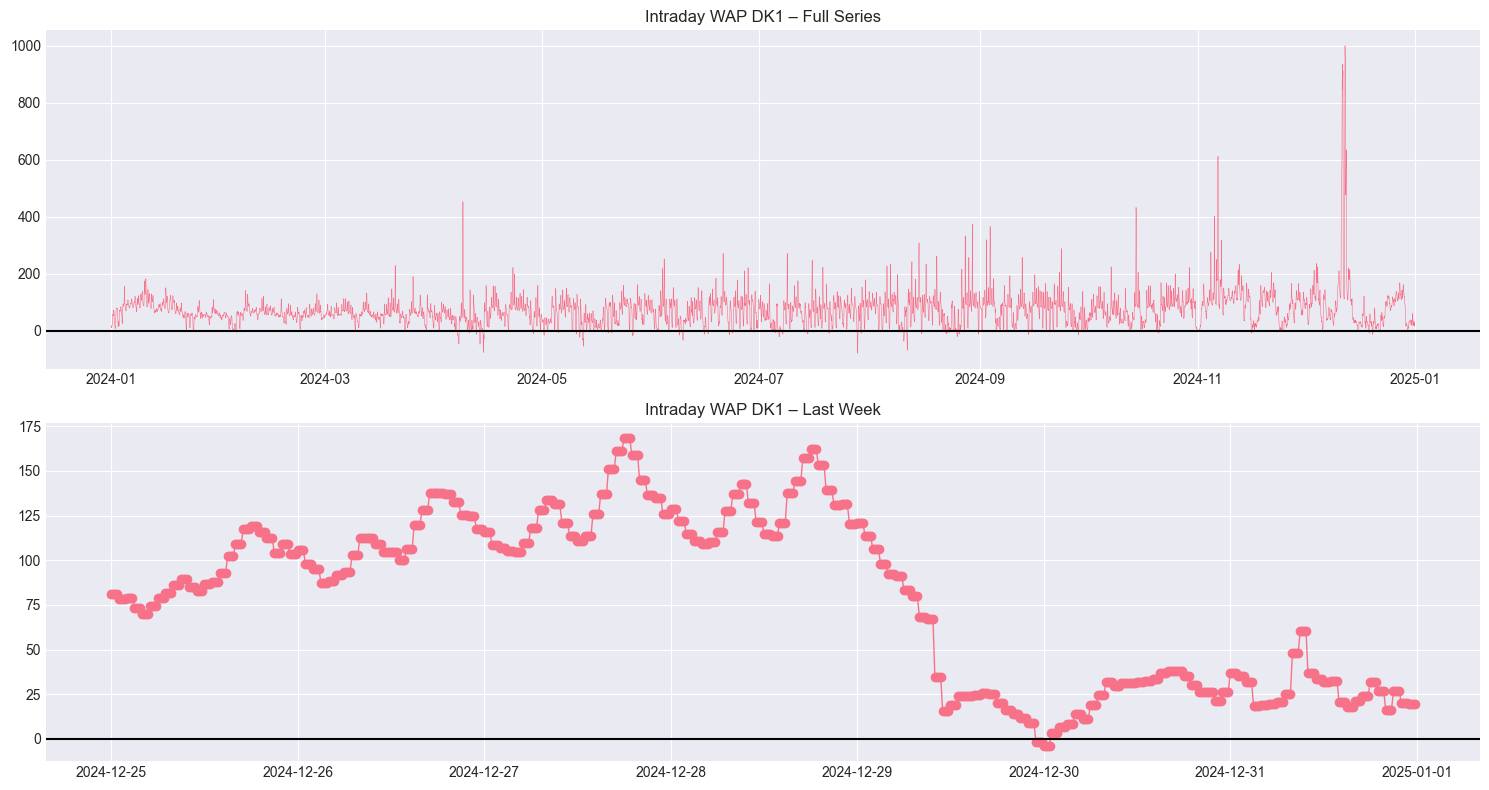

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(target, linewidth=0.4)
axes[0].axhline(0, color="black")
axes[0].set_title("Intraday WAP DK1 – Full Series")

last_week = target.last("7D")
axes[1].plot(last_week, marker="o", linewidth=1)
axes[1].axhline(0, color="black")
axes[1].set_title("Intraday WAP DK1 – Last Week")

plt.tight_layout()
plt.show()

In [9]:
stationarity = test_stationarity(target)
stationarity

{'adf_statistic': np.float64(-10.319522035198885),
 'adf_pvalue': np.float64(3.0347227775521976e-18),
 'adf_stationary': np.True_,
 'kpss_statistic': np.float64(2.3682586012679185),
 'kpss_pvalue': np.float64(0.01),
 'kpss_stationary': np.False_,
 'interpretation': 'Non-stationary'}

In [10]:
# First difference if needed
target_diff = target.diff().dropna()
test_stationarity(target_diff)

{'adf_statistic': np.float64(-22.0568199976769),
 'adf_pvalue': 0.0,
 'adf_stationary': True,
 'kpss_statistic': np.float64(0.005820624025566311),
 'kpss_pvalue': np.float64(0.1),
 'kpss_stationary': np.True_,
 'interpretation': 'Stationary'}

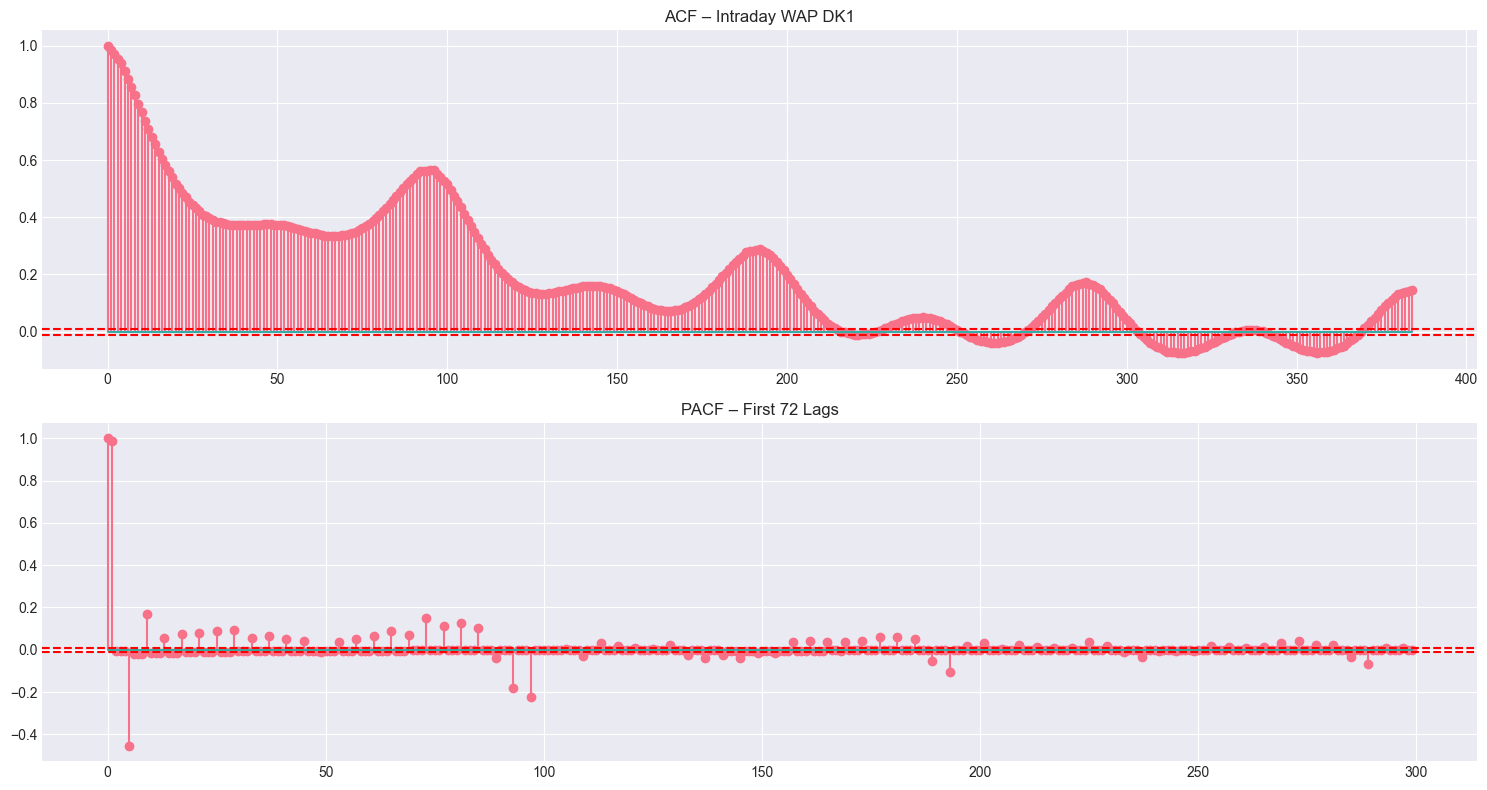

In [29]:
acf_vals, pacf_vals = compute_acf_pacf(target, nlags=24*4*4)

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].stem(acf_vals)
axes[0].axhline(1.96/np.sqrt(len(target)), color="red", linestyle="--")
axes[0].axhline(-1.96/np.sqrt(len(target)), color="red", linestyle="--")
axes[0].set_title("ACF – Intraday WAP DK1")

axes[1].stem(pacf_vals[:300])
axes[1].axhline(1.96/np.sqrt(len(target)), color="red", linestyle="--")
axes[1].axhline(-1.96/np.sqrt(len(target)), color="red", linestyle="--")
axes[1].set_title("PACF – First 72 Lags")

plt.tight_layout()
plt.show()

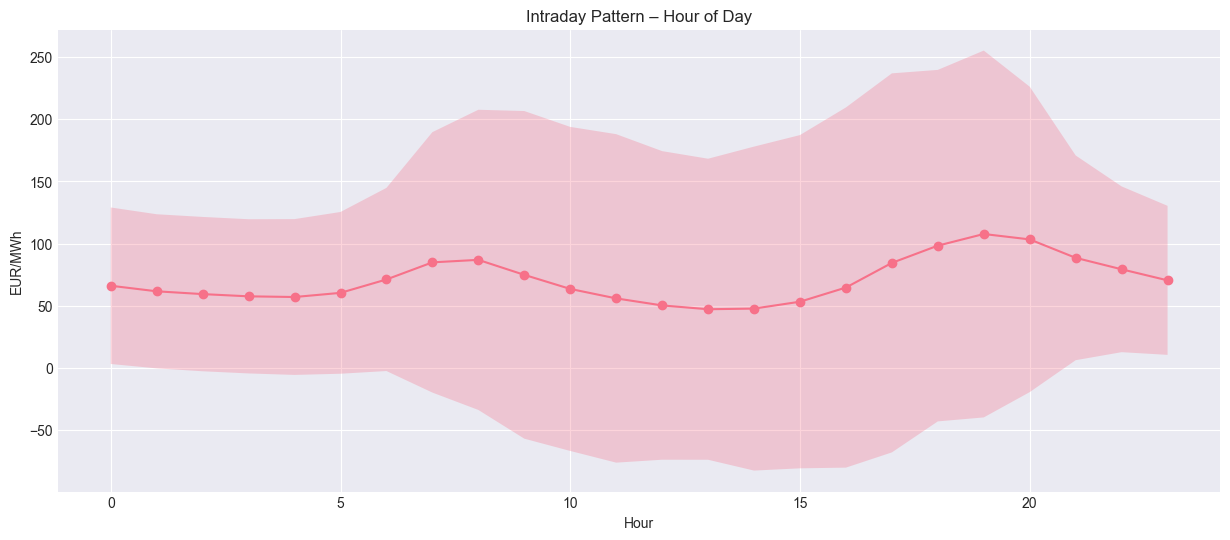

{'cv_across_hours': np.float64(0.24836350579049718),
 'range_pct': np.float64(0.8571179004616528),
 'peak_hour': np.int32(19),
 'trough_hour': np.int32(13),
 'peak_trough_ratio': np.float64(2.282383428692569)}

In [12]:
hourly_stats = target.groupby(target.index.hour).agg(["mean", "std"])

plt.plot(hourly_stats.index, hourly_stats["mean"], marker="o")
plt.fill_between(
    hourly_stats.index,
    hourly_stats["mean"] - 2 * hourly_stats["std"],
    hourly_stats["mean"] + 2 * hourly_stats["std"],
    alpha=0.3
)
plt.title("Intraday Pattern – Hour of Day")
plt.xlabel("Hour")
plt.ylabel("EUR/MWh")
plt.show()

intraday_pattern_strength(target)

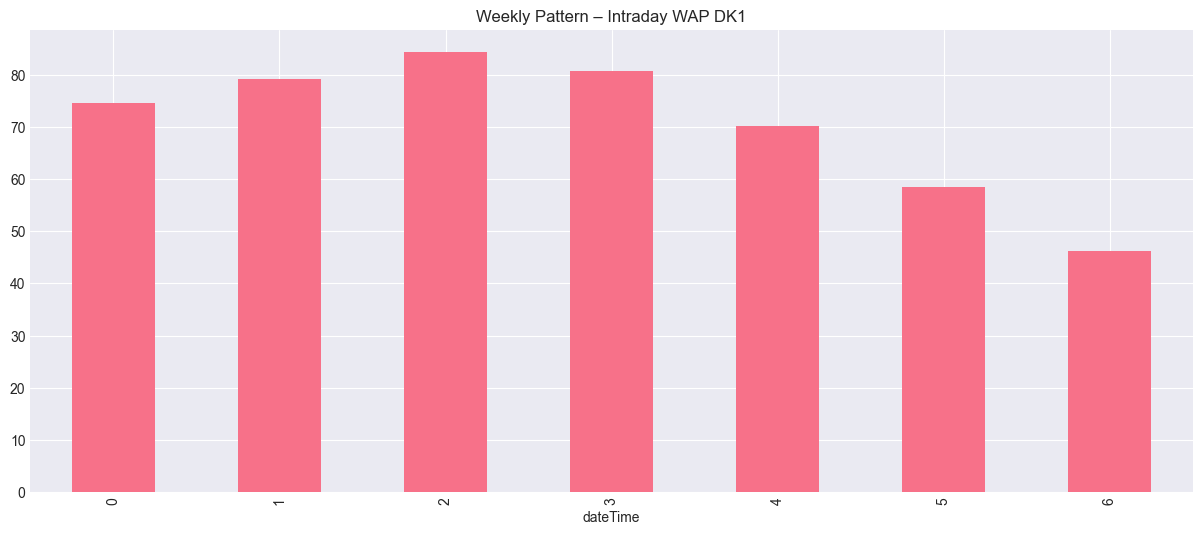

{'weekday_mean': np.float64(77.81419796202225),
 'weekend_mean': np.float64(52.35613381410256),
 'weekday_weekend_ratio': np.float64(1.4862479769478767),
 'range_pct': np.float64(0.542488337987662)}

In [13]:
# Weekly
weekly = target.groupby(target.index.dayofweek).mean()
weekly.plot(kind="bar", title="Weekly Pattern – Intraday WAP DK1")
plt.show()

weekly_pattern_strength(target)

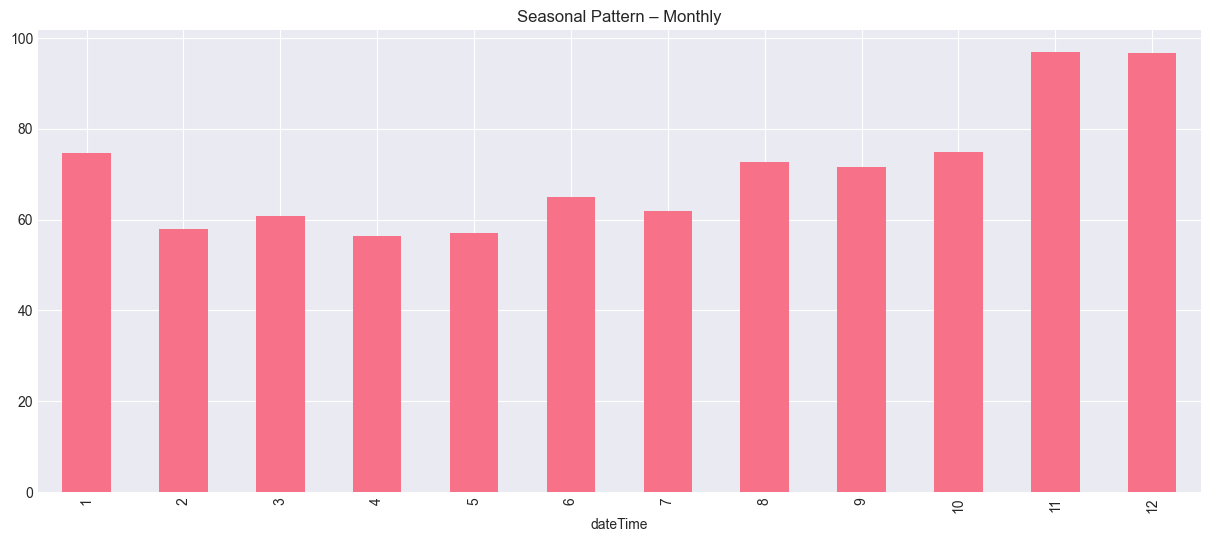

In [14]:
# Monthly
monthly = target.groupby(target.index.month).mean()
monthly.plot(kind="bar", title="Seasonal Pattern – Monthly")
plt.show()


In [15]:
neg_events = identify_negative_price_events(target)
neg_events.head()


,start,end,duration_hours,min_price
0,2024-01-22 03:00:00+01:00,2024-01-22 04:00:00+01:00,1.0,-0.29
1,2024-01-24 04:00:00+01:00,2024-01-24 05:00:00+01:00,1.0,-4.97
2,2024-02-04 04:00:00+01:00,2024-02-04 07:00:00+01:00,3.0,-1.78
3,2024-02-04 13:00:00+01:00,2024-02-04 15:00:00+01:00,2.0,-2.15
4,2024-02-05 00:00:00+01:00,2024-02-05 05:00:00+01:00,5.0,-4.88


In [16]:
spikes = detect_price_spikes(target, threshold_std=3)
target[spikes].describe()


count    264.000000
mean     461.230455
std      228.628316
min      242.470000
25%      275.230000
50%      377.380000
75%      579.020000
max      999.570000
Name: price.id.wap.HR WAP DK1, dtype: float64

In [17]:
features = df[[da_price, demand] + gen_features]
corr = compute_correlations(target, features)

corr.sort_values(ascending=False).head(15)


price.id.wap.HR WAP DK1                                1.000000
price.da.dk1.DA HR Price (EPEX)                        0.918592
gen.solar.fc.INFERRED INSTALLED CAPACITY (ENAPPSYS)    0.174258
price.da.dk1.Demand                                    0.024717
gen.solar.fc.SOLAR DA FORECAST                        -0.246963
gen.solar.fc.SOLAR OUTTURN                            -0.256527
gen.solar.fc.SOLAR FORECAST                           -0.256787
gen.solar.fc.SOLAR FORECAST (ENAPPSYS)                -0.261049
gen.solar.fc.FORECAST P90 (ENAPPSYS)                  -0.265854
gen.solar.fc.FORECAST P10 (ENAPPSYS)                  -0.269471
gen.solar.fc.DAY AHEAD FORECAST (ENAPPSYS)            -0.270863
gen.solar.fc.FORECAST UNADJUSTED (ENAPPSYS)           -0.274184
gen.wind.fc.WIND GENERATION                           -0.382115
gen.wind.fc.ONSHORE WIND FORECAST (ENAPPSYS)          -0.386625
gen.wind.fc.WIND FORECAST P10 (ENAPPSYS)              -0.411816
Name: price.id.wap.HR WAP DK1, dtype: fl

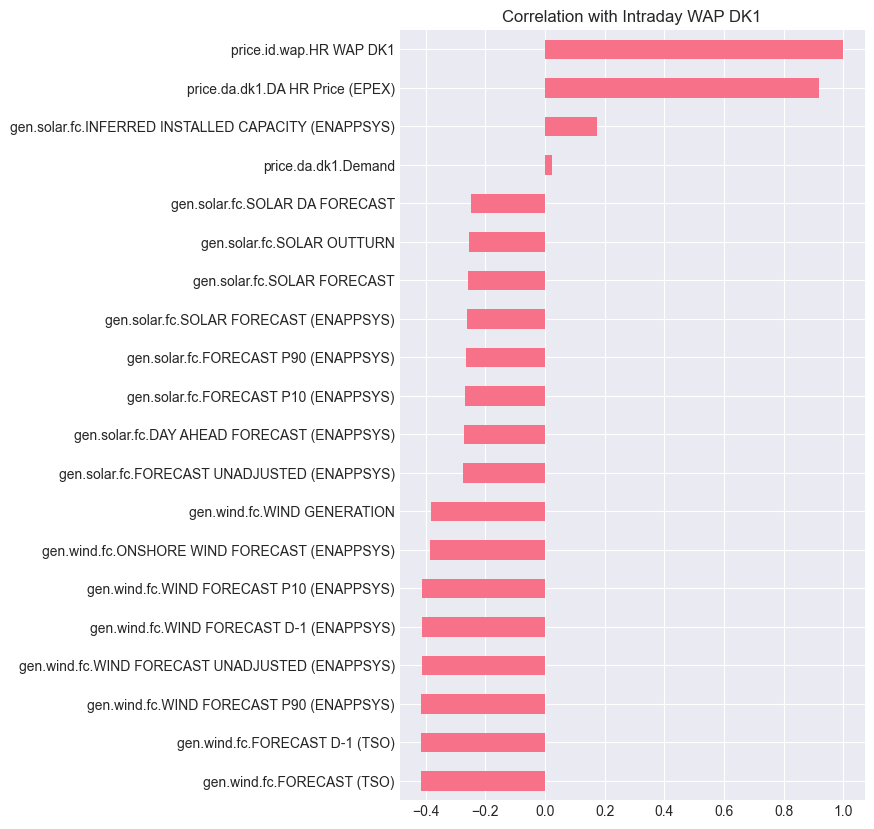

In [18]:
plt.figure(figsize=(6,10))
corr.sort_values().plot(kind="barh")
plt.title("Correlation with Intraday WAP DK1")
plt.show()


In [19]:
missing = df.isna().mean().sort_values(ascending=False)
missing.head(20)


price.id.wap.IMBALANCE PRICE DK2_lag672         0.021061
price.id.wap.IMBALANCE PRICE DK1_lag672         0.021061
price.id.wap.OPENING TRADED PRICE DK1_lag672    0.019126
price.id.wap.OPENING TRADED PRICE DK2_lag672    0.019126
price.id.wap.CLOSING TRADED PRICE DK2_lag672    0.019126
price.id.wap.CLOSING TRADED PRICE DK1_lag672    0.019126
price.id.wap.LOW TRADED PRICE DK1_lag672        0.019126
price.id.wap.LOW TRADED PRICE DK2_lag672        0.019126
price.id.wap.HR WAP DK2_lag672                  0.019126
price.id.wap.HR WAP DK1_lag672                  0.019126
price.da.dk1.Demand_lag672                      0.019126
price.da.dk1.DA HR Volume (EPEX)_lag672         0.019126
price.da.dk1.DA HR Price (EPEX)_lag672          0.019126
price.id.wap.HIGH TRADED PRICE DK1_lag672       0.019126
price.id.wap.HIGH TRADED PRICE DK2_lag672       0.019126
gen.solar.fc.DAY AHEAD FORECAST (ENAPPSYS)      0.018556
gen.wind.fc.FORECAST (TSO)                      0.016507
gen.wind.fc.FORECAST D-1 (TSO) 

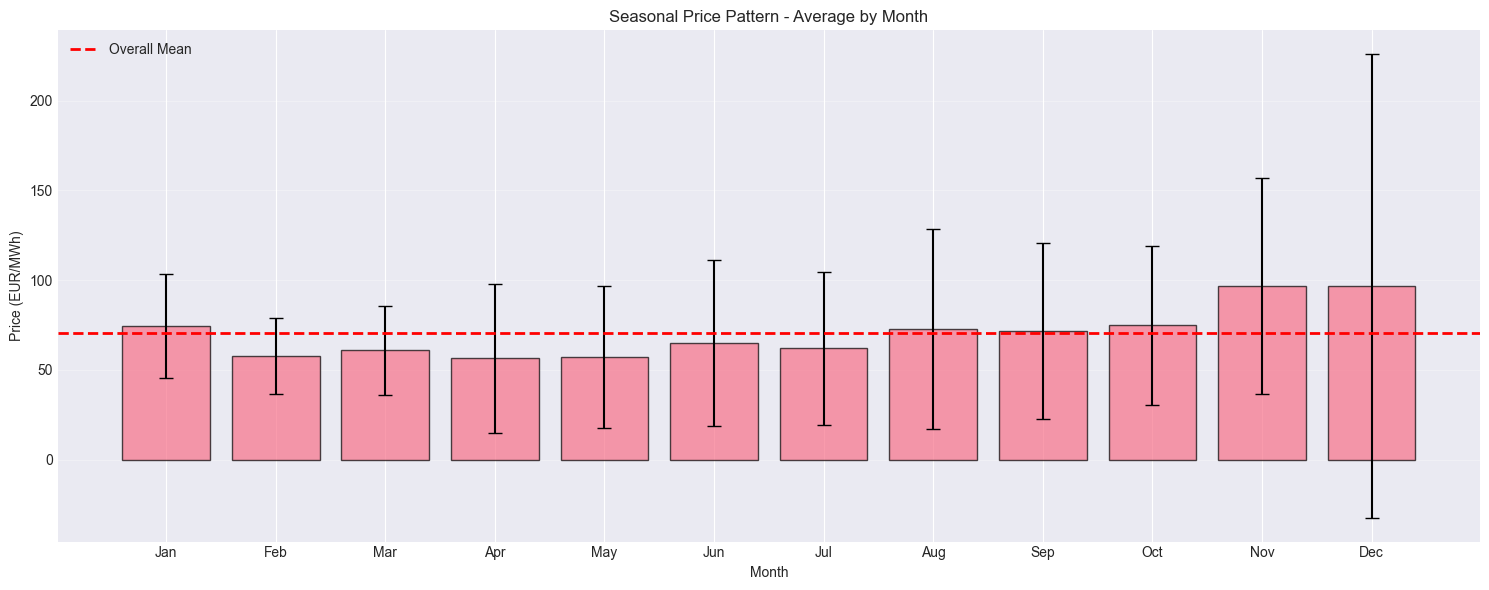

SEASONAL PATTERN ANALYSIS

📊 SEASONAL COMPARISON:
  Winter (Dec-Feb): 76.82 EUR/MWh
  Summer (Jun-Aug): 66.54 EUR/MWh
  Winter/summer ratio: 1.15x

💡 INSIGHT:
   - Winter: Higher heating demand → higher prices
   - Summer: Lower demand OR high solar generation → lower prices
   - Transition months (Apr, Oct) show moderate prices


In [20]:
# Calculate monthly statistics
monthly_stats = target.groupby(target.index.month).agg(['mean', 'std', 'min', 'max'])

# Plot seasonal pattern
fig, ax = plt.subplots(figsize=(15, 6))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = range(1, 13)

ax.bar(x, monthly_stats['mean'], yerr=monthly_stats['std'], capsize=5, alpha=0.7, edgecolor='black')
ax.set_xlabel('Month')
ax.set_ylabel('Price (EUR/MWh)')
ax.set_title('Seasonal Price Pattern - Average by Month')
ax.set_xticks(x)
ax.set_xticklabels(months)
ax.axhline(target.mean(), color='red', linestyle='--', linewidth=2, label='Overall Mean')
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("=" * 80)
print("SEASONAL PATTERN ANALYSIS")
print("=" * 80)

winter_months = [1, 2, 12]
summer_months = [6, 7, 8]

winter_mean = target[target.index.month.isin(winter_months)].mean()
summer_mean = target[target.index.month.isin(summer_months)].mean()

print(f"\n📊 SEASONAL COMPARISON:")
print(f"  Winter (Dec-Feb): {winter_mean:.2f} EUR/MWh")
print(f"  Summer (Jun-Aug): {summer_mean:.2f} EUR/MWh")
print(f"  Winter/summer ratio: {winter_mean/summer_mean:.2f}x")

print("\n💡 INSIGHT:")
print("   - Winter: Higher heating demand → higher prices")
print("   - Summer: Lower demand OR high solar generation → lower prices")
print("   - Transition months (Apr, Oct) show moderate prices")



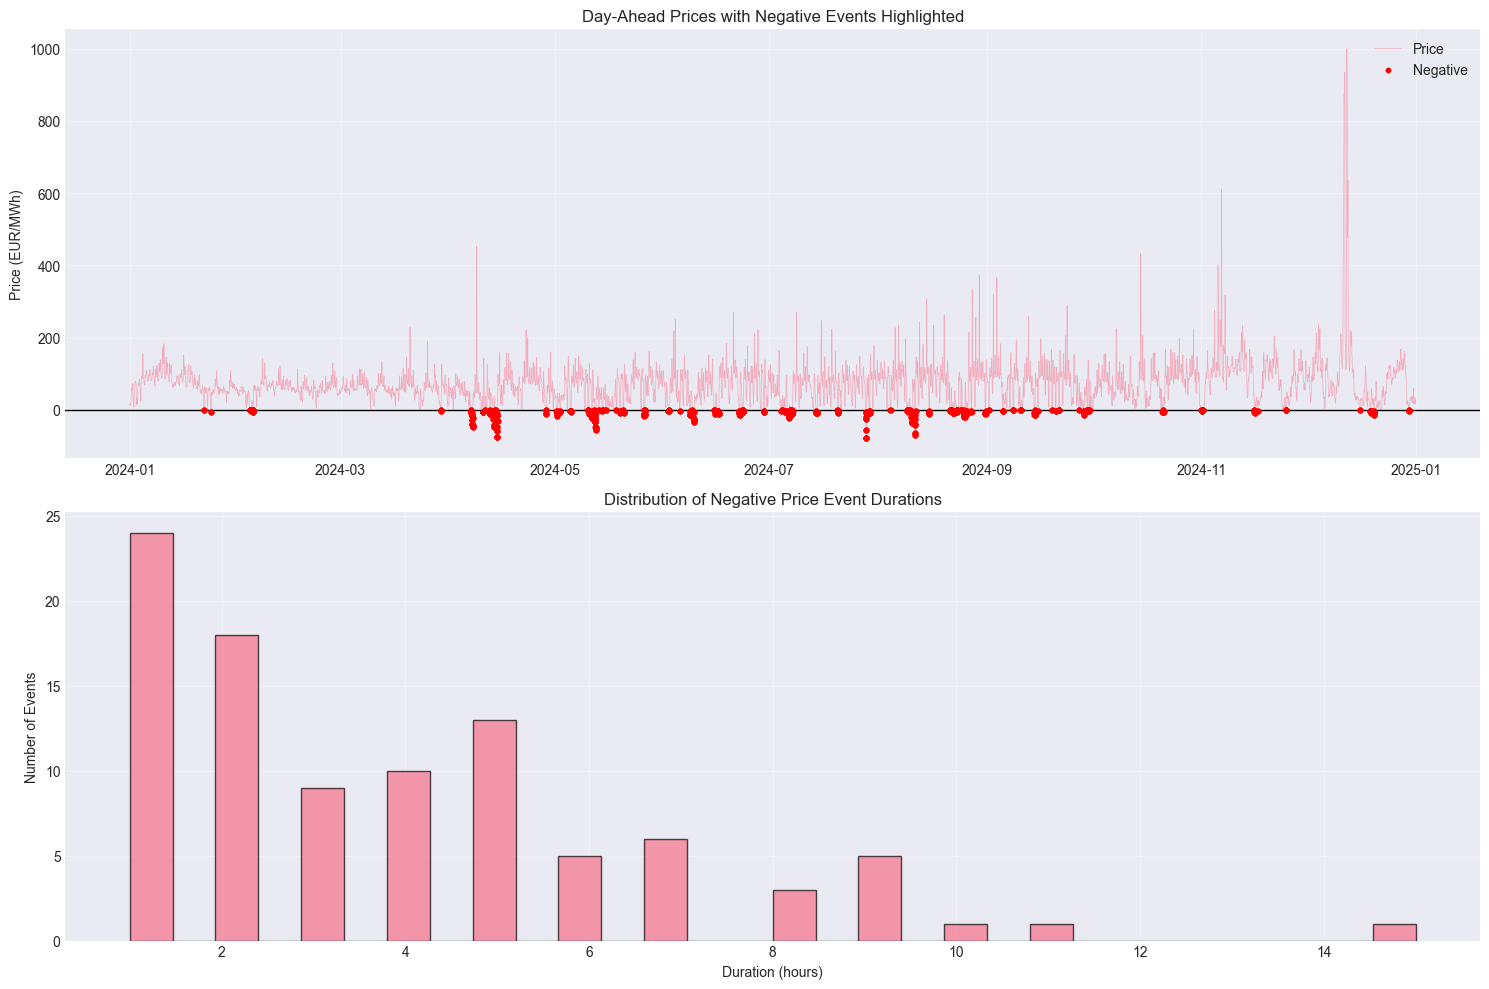

NEGATIVE PRICE EVENT ANALYSIS

📊 EVENT STATISTICS:
  Total events: 96
  Total hours: 369.0
  Avg duration: 3.84 hours
  Max duration: 15.00 hours
  Lowest price: -79.08 EUR/MWh

📅 TEMPORAL DISTRIBUTION:
  Jan: 2 events
  Feb: 3 events
  Mar: 1 events
  Apr: 9 events
  May: 13 events
  Jun: 12 events
  Jul: 12 events
  Aug: 20 events
  Sep: 14 events
  Oct: 1 events
  Nov: 5 events
  Dec: 4 events

💡 INSIGHT:
   - Negative prices occur when supply exceeds demand
   - Common causes: High wind/solar + low demand (weekends, nights)
   - More frequent in months with high renewable generation


In [21]:
# Identify negative price events
neg_events = identify_negative_price_events(target, threshold=0)

if len(neg_events) > 0:
    # Plot negative prices over time
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Time series with negative prices highlighted
    axes[0].plot(target.index, target, linewidth=0.5, alpha=0.5, label='Price')
    neg_mask = target < 0
    axes[0].scatter(target[neg_mask].index, target[neg_mask], color='red', s=10, label='Negative', zorder=5)
    axes[0].axhline(0, color='black', linestyle='-', linewidth=1)
    axes[0].set_ylabel('Price (EUR/MWh)')
    axes[0].set_title('Day-Ahead Prices with Negative Events Highlighted')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Negative event characteristics
    axes[1].hist(neg_events['duration_hours'], bins=30, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Duration (hours)')
    axes[1].set_ylabel('Number of Events')
    axes[1].set_title('Distribution of Negative Price Event Durations')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 80)
    print("NEGATIVE PRICE EVENT ANALYSIS")
    print("=" * 80)
    
    print(f"\n📊 EVENT STATISTICS:")
    print(f"  Total events: {len(neg_events)}")
    print(f"  Total hours: {neg_events['duration_hours'].sum():.1f}")
    print(f"  Avg duration: {neg_events['duration_hours'].mean():.2f} hours")
    print(f"  Max duration: {neg_events['duration_hours'].max():.2f} hours")
    print(f"  Lowest price: {neg_events['min_price'].min():.2f} EUR/MWh")
    
    print(f"\n📅 TEMPORAL DISTRIBUTION:")
    neg_by_month = pd.Series(neg_events['start'].dt.month.value_counts().sort_index())
    for month, count in neg_by_month.items():
        print(f"  {months[month-1]}: {count} events")
    
    print("\n💡 INSIGHT:")
    print("   - Negative prices occur when supply exceeds demand")
    print("   - Common causes: High wind/solar + low demand (weekends, nights)")
    print("   - More frequent in months with high renewable generation")
    
else:
    print("✓ No negative price events found in the dataset")



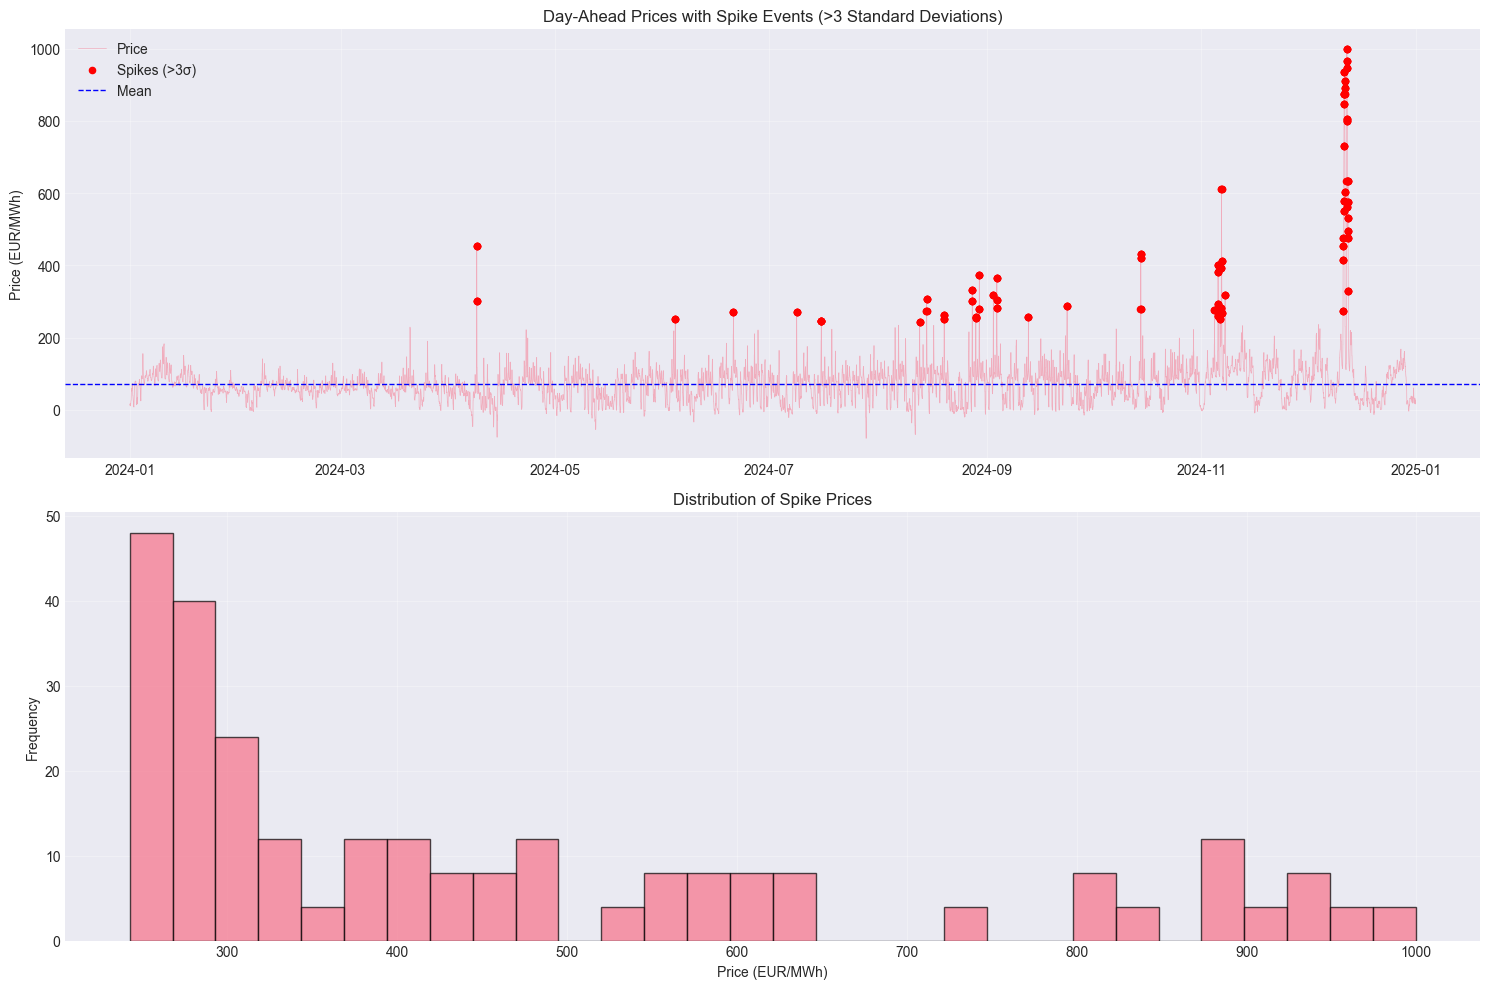

PRICE SPIKE ANALYSIS

📊 SPIKE STATISTICS:
  Total spikes: 264 (0.75% of observations)
  Mean spike price: 461.23 EUR/MWh
  Median spike price: 377.38 EUR/MWh
  Max spike price: 999.57 EUR/MWh

⏰ SPIKE TIMING (top 5 hours):
  Hour 19: 60 spikes
  Hour 20: 48 spikes
  Hour 17: 28 spikes
  Hour 18: 24 spikes
  Hour 07: 16 spikes

💡 INSIGHT:
   - Spikes occur during supply shortage or extreme demand
   - Often correlated with: Low wind, equipment outages, cold snaps
   - Critical for risk management and bidding strategies


In [22]:
# Detect price spikes
spikes = detect_price_spikes(target, threshold_std=3)
spike_prices = target[spikes]

# Plot spikes
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Time series with spikes highlighted
axes[0].plot(target.index, target, linewidth=0.5, alpha=0.5, label='Price')
axes[0].scatter(spike_prices.index, spike_prices, color='red', s=20, label='Spikes (>3σ)', zorder=5)
axes[0].axhline(target.mean(), color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].set_ylabel('Price (EUR/MWh)')
axes[0].set_title('Day-Ahead Prices with Spike Events (>3 Standard Deviations)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Spike distribution
axes[1].hist(spike_prices, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Price (EUR/MWh)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Spike Prices')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 80)
print("PRICE SPIKE ANALYSIS")
print("=" * 80)

print(f"\n📊 SPIKE STATISTICS:")
print(f"  Total spikes: {spikes.sum()} ({spikes.mean():.2%} of observations)")
print(f"  Mean spike price: {spike_prices.mean():.2f} EUR/MWh")
print(f"  Median spike price: {spike_prices.median():.2f} EUR/MWh")
print(f"  Max spike price: {spike_prices.max():.2f} EUR/MWh")

# Spike timing analysis
if len(spike_prices) > 0:
    spike_by_hour = spike_prices.groupby(spike_prices.index.hour).size()
    print(f"\n⏰ SPIKE TIMING (top 5 hours):")
    for hour, count in spike_by_hour.sort_values(ascending=False).head().items():
        print(f"  Hour {hour:02d}: {count} spikes")

print("\n💡 INSIGHT:")
print("   - Spikes occur during supply shortage or extreme demand")
print("   - Often correlated with: Low wind, equipment outages, cold snaps")
print("   - Critical for risk management and bidding strategies")



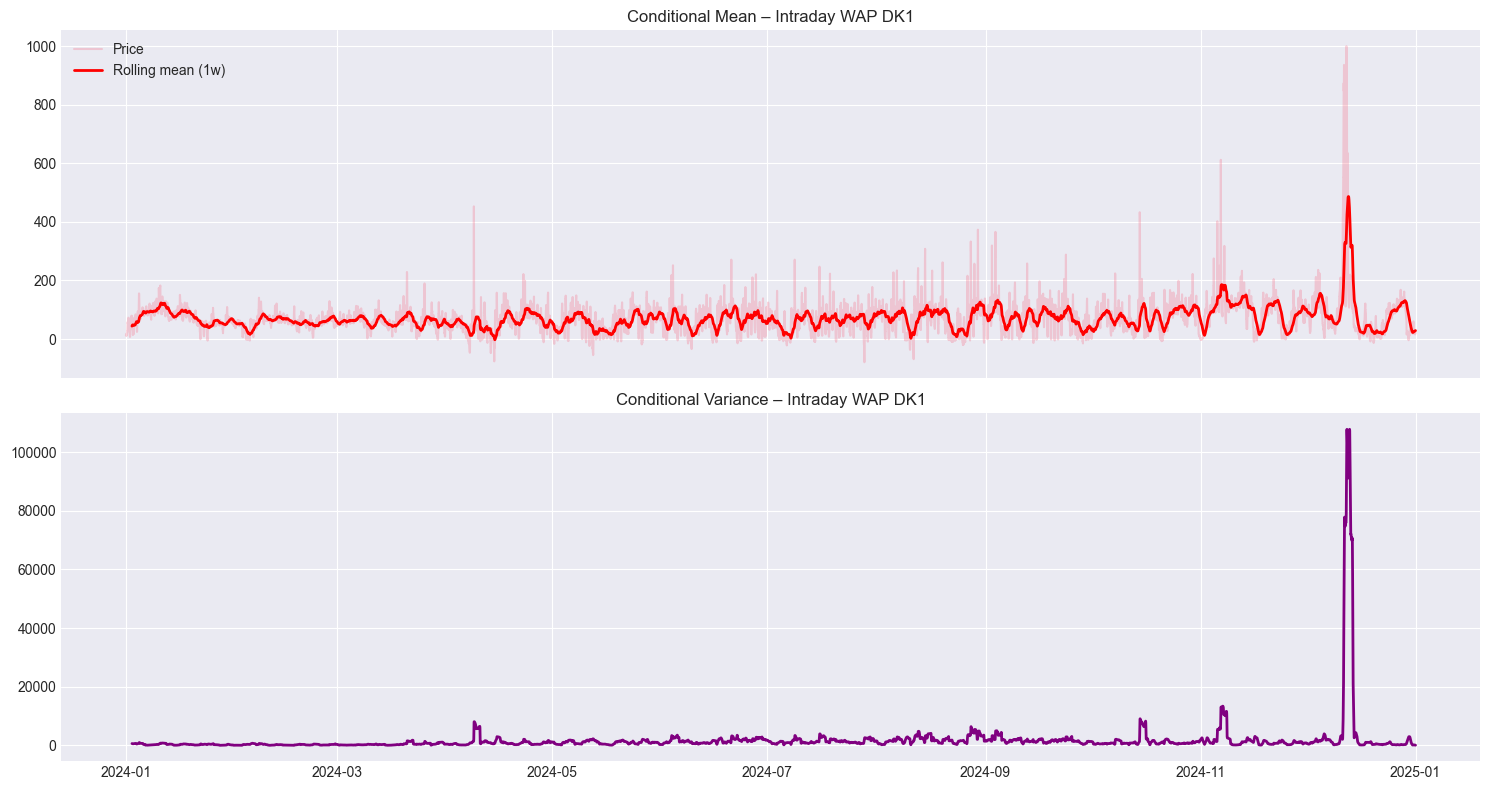

In [23]:
# ==========================================
# Conditional Mean & Variance (Rolling)
# ==========================================

window = 24 * 7  # 1 week rolling window

rolling_mean = target.rolling(window).mean()
rolling_var = target.rolling(window).var()

fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

axes[0].plot(target, alpha=0.3, label="Price")
axes[0].plot(rolling_mean, color="red", linewidth=2, label="Rolling mean (1w)")
axes[0].set_title("Conditional Mean – Intraday WAP DK1")
axes[0].legend()

axes[1].plot(rolling_var, color="purple", linewidth=2)
axes[1].set_title("Conditional Variance – Intraday WAP DK1")

plt.tight_layout()
plt.show()


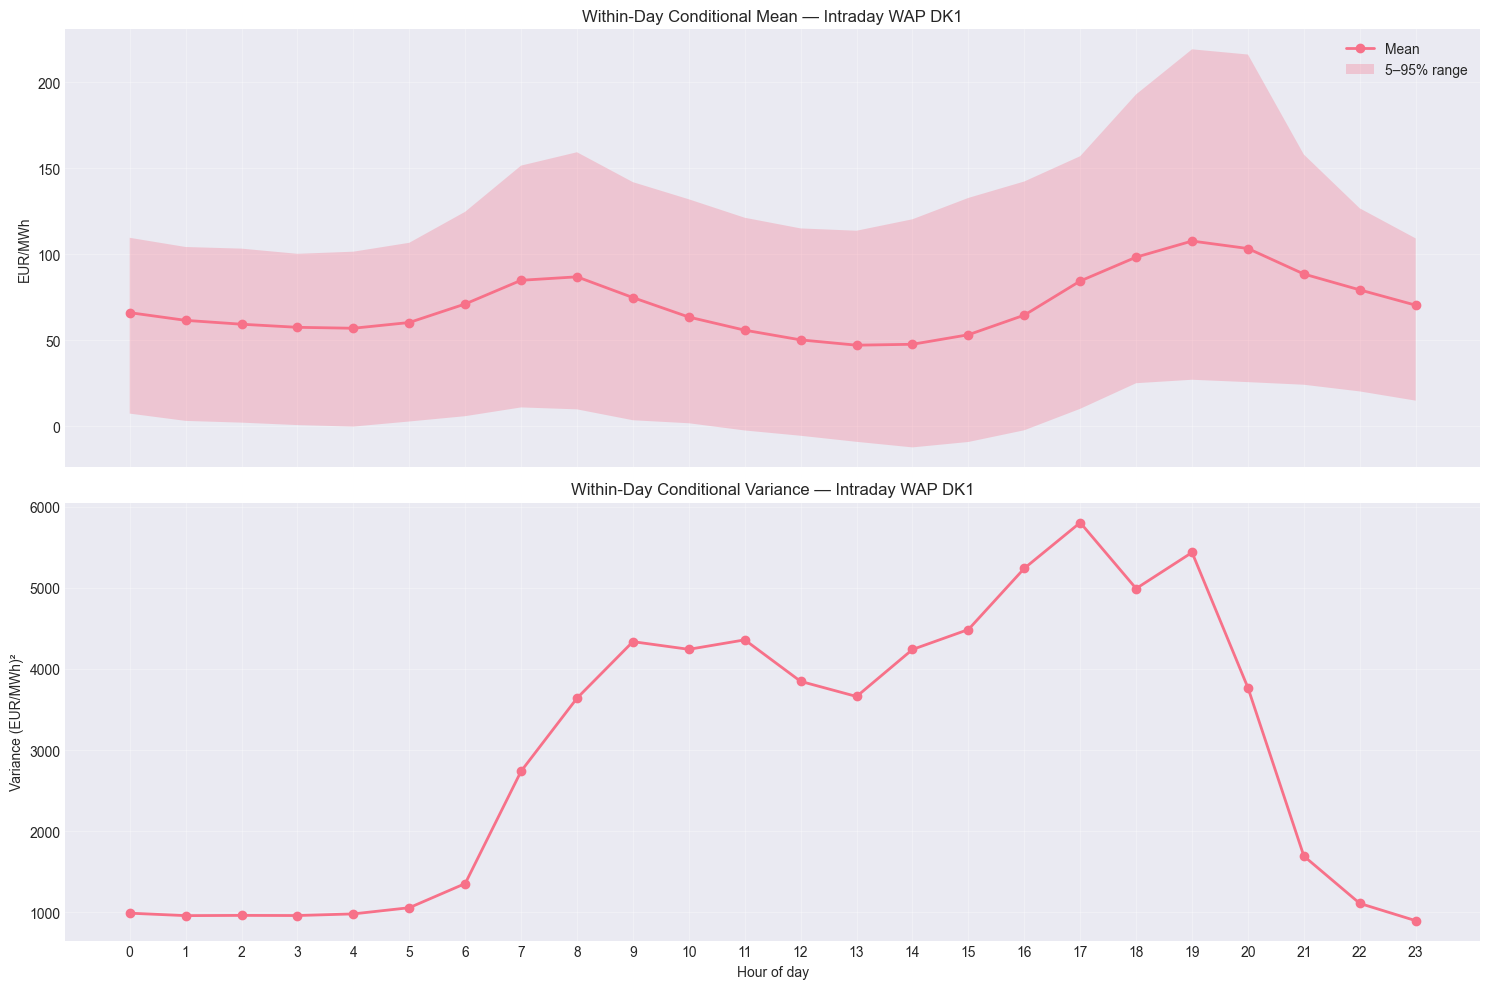

In [26]:
import matplotlib.pyplot as plt

# Target: Intraday WAP DK1
TARGET = "price.id.wap.HR WAP DK1"
target = df[TARGET].dropna()

# Group by hour of day
within_day = target.groupby(target.index.hour).agg(
    mean="mean",
    variance="var",
    std="std",
    q05=lambda x: x.quantile(0.05),
    q95=lambda x: x.quantile(0.95),
)

hours = within_day.index

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# ---- Conditional mean ----
axes[0].plot(hours, within_day["mean"], marker="o", linewidth=2, label="Mean")
axes[0].fill_between(
    hours,
    within_day["q05"],
    within_day["q95"],
    alpha=0.3,
    label="5–95% range"
)
axes[0].set_title("Within-Day Conditional Mean — Intraday WAP DK1")
axes[0].set_ylabel("EUR/MWh")
axes[0].legend()
axes[0].grid(alpha=0.3)

# ---- Conditional variance ----
axes[1].plot(hours, within_day["variance"], marker="o", linewidth=2)
axes[1].set_title("Within-Day Conditional Variance — Intraday WAP DK1")
axes[1].set_xlabel("Hour of day")
axes[1].set_ylabel("Variance (EUR/MWh)²")
axes[1].grid(alpha=0.3)

plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


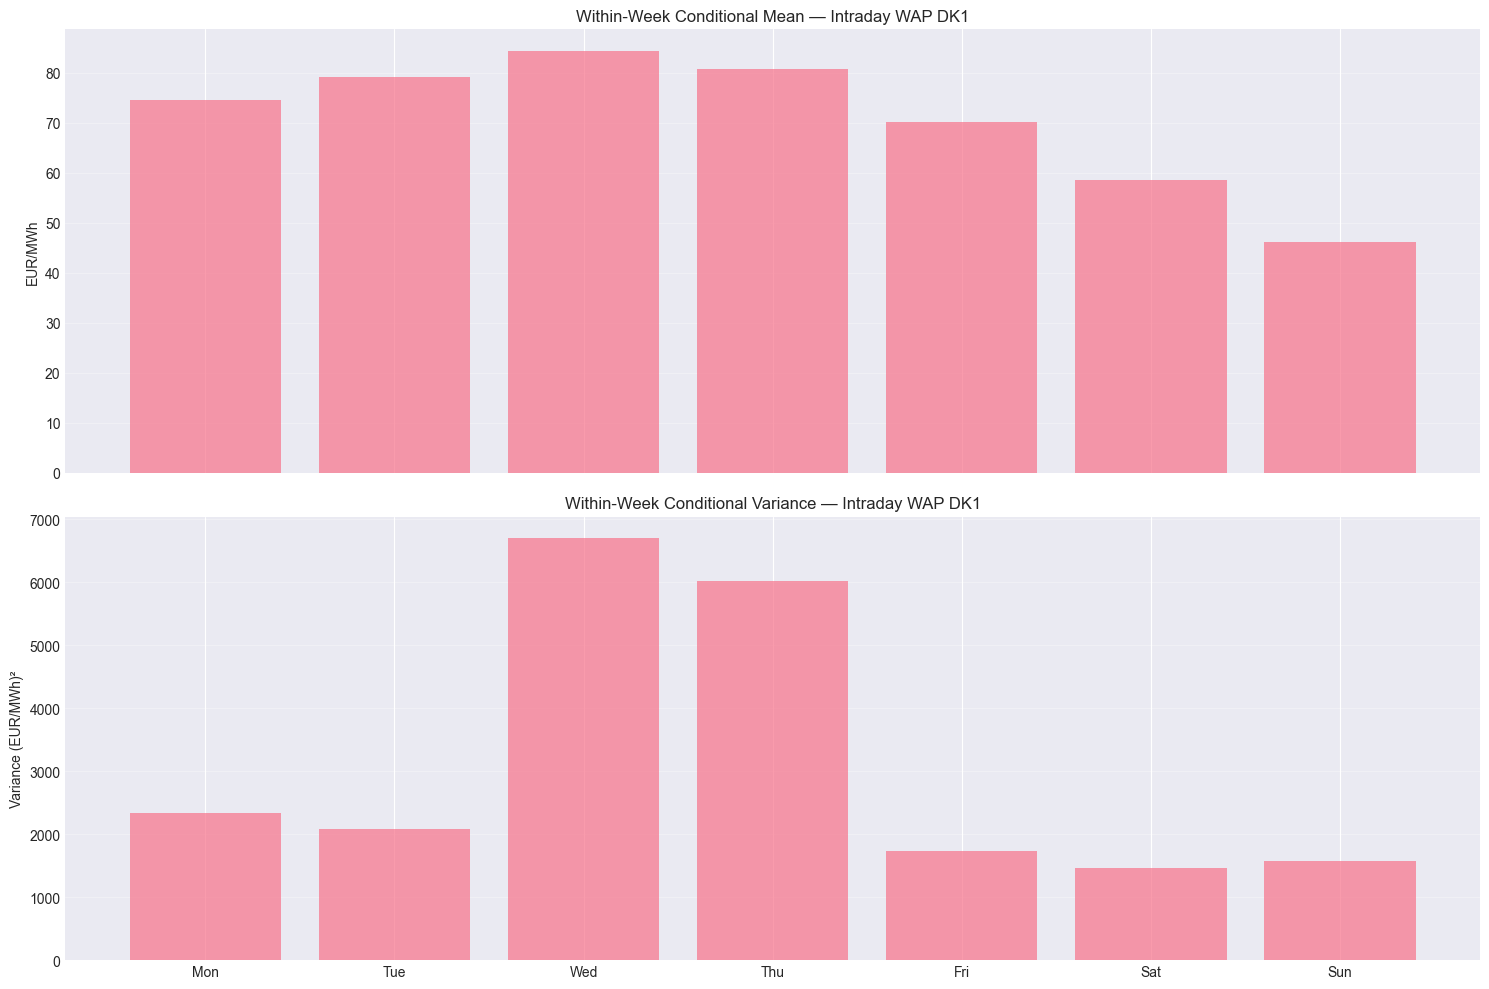

In [27]:
# Group by day of week (0=Mon)
within_week = target.groupby(target.index.dayofweek).agg(
    mean="mean",
    variance="var",
    std="std",
    q05=lambda x: x.quantile(0.05),
    q95=lambda x: x.quantile(0.95),
)

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# ---- Conditional mean ----
axes[0].bar(days, within_week["mean"], alpha=0.7)
axes[0].set_title("Within-Week Conditional Mean — Intraday WAP DK1")
axes[0].set_ylabel("EUR/MWh")
axes[0].grid(alpha=0.3, axis="y")

# ---- Conditional variance ----
axes[1].bar(days, within_week["variance"], alpha=0.7)
axes[1].set_title("Within-Week Conditional Variance — Intraday WAP DK1")
axes[1].set_ylabel("Variance (EUR/MWh)²")
axes[1].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()


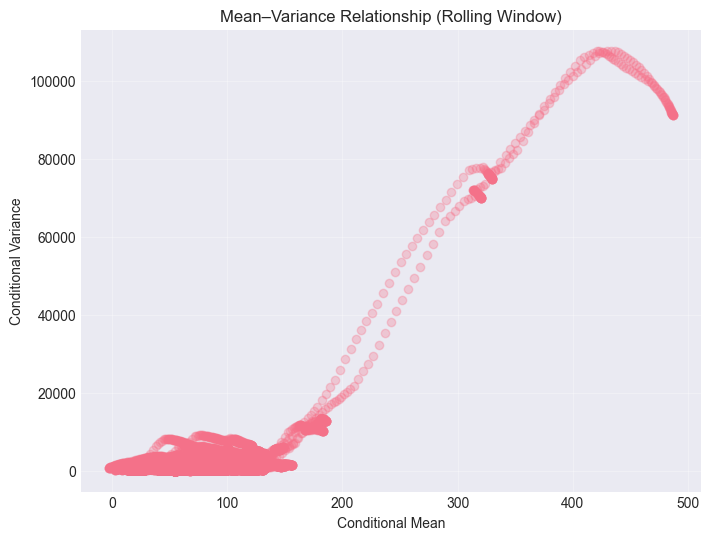

In [24]:
# ==========================================
# Mean–Variance Relationship
# ==========================================

mv_df = pd.DataFrame({
    "mean": rolling_mean,
    "variance": rolling_var
}).dropna()

plt.figure(figsize=(8, 6))
plt.scatter(mv_df["mean"], mv_df["variance"], alpha=0.3)
plt.xlabel("Conditional Mean")
plt.ylabel("Conditional Variance")
plt.title("Mean–Variance Relationship (Rolling Window)")
plt.grid(alpha=0.3)
plt.show()


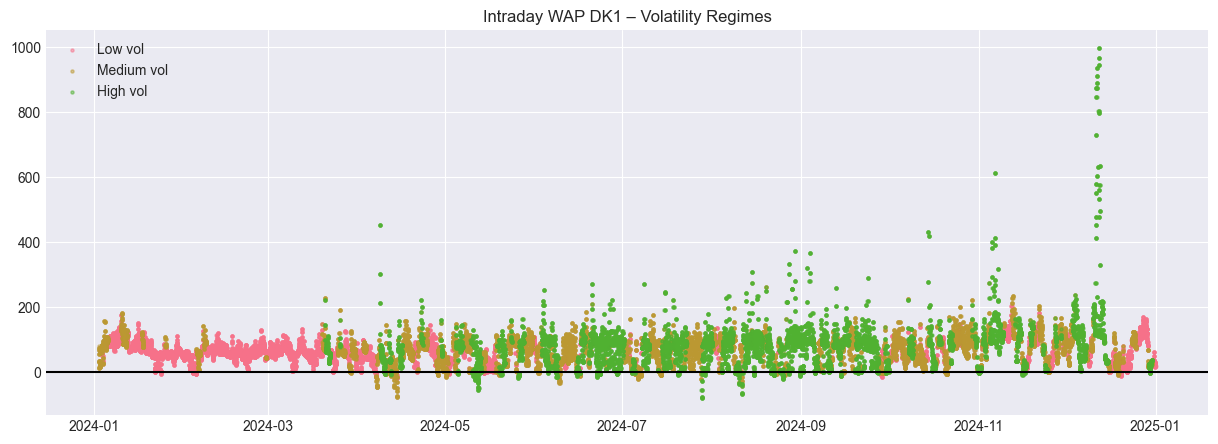

In [25]:
# ==========================================
# Volatility Regime Identification
# ==========================================

vol_q = rolling_var.quantile([0.33, 0.66])

regime = pd.Series(index=rolling_var.index, dtype="object")
regime[rolling_var <= vol_q.iloc[0]] = "Low vol"
regime[(rolling_var > vol_q.iloc[0]) & (rolling_var <= vol_q.iloc[1])] = "Medium vol"
regime[rolling_var > vol_q.iloc[1]] = "High vol"

fig, ax = plt.subplots(figsize=(15, 5))

for r, color in zip(["Low vol", "Medium vol", "High vol"],
                    ["green", "orange", "red"]):
    mask = regime == r
    ax.scatter(
        target.index[mask],
        target[mask],
        s=5,
        label=r,
        alpha=0.5
    )

ax.axhline(0, color="black")
ax.set_title("Intraday WAP DK1 – Volatility Regimes")
ax.legend()
plt.show()


In [ ]:
# 5-10 yrs of data
# springs are easy
# persistent regimes
# could be regime shifting or garch
# all differences should be added to the model
# AR benchmark or seasonal AR benchmark then regime shifting
# in the model the variance itself is a function of an ex var
# demand, renewable forecast, da price **, 
# patterns during the day
# "type of day" wd or holiday, day of the week patterns
# we should see trends -> reestimated modelling
# write the data section
# meeting in 2 weeks